In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scienceplots
import seaborn as sns
from lobib import DataLoader
from matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

os.makedirs("../figures/fit", exist_ok=True)


def save_fig(name):
    plt.savefig(f"../report/figures/{name}.pdf", bbox_inches="tight")
    plt.savefig(f"../report/figures/{name}.png", bbox_inches="tight", dpi=300)


HOURS_PER_DAY = 5.5
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)
TICK_TO_USD = 0.01
FIVE_MIN_NS = int(5 * 60 * 1e9)

In [2]:
loader = DataLoader()


def pl_select(condlist: list[pl.Expr], choicelist: list[pl.Expr]) -> pl.Expr:
    return reduce(
        lambda expr, cond_choice: expr.when(cond_choice[0]).then(cond_choice[1]),
        zip(condlist, choicelist),
        pl.when(condlist[0]).then(choicelist[0]),
    )


def imbalance_exp(mes: int) -> tuple[pl.Expr, pl.Expr]:
    condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
    choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
    best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(mes).ceil()

    condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
    choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
    best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(mes).ceil()
    imb = ((best_bid - best_ask) / (best_bid + best_ask)).alias("imb")

    bins = np.arange(11, step=1) / 10
    condlist = [
        *[
            pl.col("imb").ge(left) & pl.col("imb").lt(right)
            for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
        ],
        pl.col("imb").eq(0),
        *[
            pl.col("imb").gt(left) & pl.col("imb").le(right)
            for left, right in zip(bins[:-1], bins[1:])
        ],
    ]
    choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
    imb_bin = pl_select(condlist, choicelist).alias("imb_bin")
    return imb, imb_bin


def load_ticker(ticker: str) -> pl.DataFrame:
    info = loader.ticker_info(ticker)
    df = loader.load(
        ticker,
        start_date=info["date"].min(),
        end_date=info["date"].max(),
        schema="qr",
        eager=True,
    ).sort(["date", "ts_event"])
    df = df.filter(
        (
            pl.col("event_side")
            .replace({"A": 1, "B": -1})
            .cast(int)
            .mul(pl.col("event_queue_nbr"))
            >= 0
        )
    )
    df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
    df = df.with_columns(
        pl.when(pl.col("event_queue_nbr").lt(0))
        .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
        .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
        .alias("event_q")
    )
    mes = (
        pl.read_csv(f"../data/{ticker}/median_event_sizes.csv")
        .filter(pl.col("queue_level").eq(1))["median_event_size"]
        .item()
    )
    imb, imb_bin = imbalance_exp(mes)
    df = df.with_columns(imb).with_columns(imb_bin)
    df = df.filter(pl.col("event_q").abs().le(2))
    df = df.with_columns(
        pl.when(pl.col("spread").ge(2))
        .then(2)
        .otherwise(pl.col("spread"))
        .alias("spread")
    )
    df = df.with_columns(pl.col("P_1").add(pl.col("P_-1")).truediv(2).alias("mid"))
    return df


def compute_dt(df: pl.DataFrame) -> pl.DataFrame:
    dt = df.select(
        pl.col("ts_event").diff().over("date").cast(int).alias("dt"),
        "imb_bin",
        "spread",
    ).filter(pl.col("dt").gt(0))
    dt = dt.with_columns(pl.col("dt").log10().alias("dt_log"))
    return dt


def compute_eta(
    df: pl.DataFrame, date_col: str = "date", mid_col: str = "mid"
) -> pl.DataFrame:
    """Compute eta per trading day."""
    return (
        df.with_columns(pl.col(mid_col).diff().over(date_col).alias("mid_diff"))
        .with_columns(
            pl.col("mid_diff").sign().alias("sign"),
            pl.col("mid_diff").sign().shift(1).over(date_col).alias("prev_sign"),
        )
        .filter(
            pl.col("mid_diff").ne(0)
            & pl.col("prev_sign").is_not_null()
            & pl.col("prev_sign").ne(0)
        )
        .with_columns(
            (pl.col("sign") == pl.col("prev_sign")).alias("is_continuation"),
            (pl.col("sign") != pl.col("prev_sign")).alias("is_alternation"),
        )
        .group_by(date_col)
        .agg(
            pl.col("is_continuation").sum().alias("n_continuations"),
            pl.col("is_alternation").sum().alias("n_alternations"),
        )
        .with_columns(
            (pl.col("n_continuations") / (2 * pl.col("n_alternations"))).alias("eta")
        )
    )


def compute_volatility_sampled_empirical(df: pl.LazyFrame, sample_interval_ns: int = FIVE_MIN_NS) -> pl.DataFrame:
  return (
      df
      .filter(pl.col("event") == "Trd")
      .with_columns(
          (pl.col("ts_event").dt.epoch("ns") // sample_interval_ns).alias("time_bucket")
      )
      .group_by(["date", "time_bucket"])
      .agg(pl.col("price").last())
      .sort(["date", "time_bucket"])
      .with_columns(
          (pl.col("price") * TICK_TO_USD).diff().over("date").alias("price_diff")
      )
      .filter(pl.col("price_diff").is_not_null())
      .group_by("date")
      .agg((pl.col("price_diff") ** 2).sum().alias("realized_var"))
      .with_columns(
          (pl.col("realized_var") / HOURS_PER_DAY).sqrt().alias("volatility_per_hour")
      )
  )

def compute_volatility_sampled_simulation(df: pl.LazyFrame, sample_interval_ns: int = FIVE_MIN_NS) -> pl.DataFrame:
  return (
      df
      .filter(pl.col("event") == "Trade")
      .with_columns(
          (pl.col("ts_event") // sample_interval_ns).alias("time_bucket"),
          (pl.col("ts_event") // DAY_NS).alias("date")
      )
      .group_by(["date", "time_bucket"])
      .agg(pl.col("price").last())
      .sort(["date", "time_bucket"])
      .with_columns(
          (pl.col("price") * TICK_TO_USD).diff().over("date").alias("price_diff")
      )
      .filter(pl.col("price_diff").is_not_null())
      .group_by("date")
      .agg((pl.col("price_diff") ** 2).sum().alias("realized_var"))
      .with_columns(
          (pl.col("realized_var") / HOURS_PER_DAY).sqrt().alias("volatility_per_hour")
      )
  )


def preprocess_sim(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns((pl.col("ts_event") // DAY_NS).alias("date"))
    df = df.filter(~pl.col("rejected"))
    df = df.with_columns(pl.col("ts_event").diff().alias("dt"))
    bins = np.arange(11, step=1) / 10
    condlist = [
        *[
            pl.col("imb").ge(left) & pl.col("imb").lt(right)
            for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
        ],
        pl.col("imb").eq(0),
        *[
            pl.col("imb").gt(left) & pl.col("imb").le(right)
            for left, right in zip(bins[:-1], bins[1:])
        ],
    ]
    choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
    df = df.with_columns(imb_bin=pl_select(condlist, choicelist))
    return df

In [3]:
ticker = "PFE"
df = load_ticker(ticker)
# df = df.with_columns(pl.col("ts_event").diff().over("date").cast(int).alias("dt"))
dt = compute_dt(df)

In [4]:
df.filter(pl.col("event").eq("Trd")).select("ts_event", pl.when(pl.col("event_side").eq("A")).then(1).otherwise(-1))

ts_event,literal
"datetime[ns, US/Eastern]",i32
2023-12-14 10:00:00.126155670 EST,1
2023-12-14 10:00:00.343408294 EST,1
2023-12-14 10:00:00.344174935 EST,1
2023-12-14 10:00:00.344234714 EST,1
2023-12-14 10:00:00.352855337 EST,1
…,…
2025-12-23 15:28:22.518022637 EST,1
2025-12-23 15:28:29.604502492 EST,1
2025-12-23 15:28:29.604539562 EST,1


In [5]:
df_exp = pl.read_parquet(f"../data/results/{ticker}/result_exp.parquet")
df_mix = pl.read_parquet(f"../data/results/{ticker}/result_mix.parquet")
df_exp_lvl = pl.read_parquet(f"../data/results/{ticker}/result_exp_totallvl.parquet")

In [6]:
df_exp = preprocess_sim(df_exp)
df_mix = preprocess_sim(df_mix)
df_exp_lvl = preprocess_sim(df_exp_lvl)

In [7]:
dt_exp = (
    df_exp.select("dt")
    .filter(pl.col("dt").gt(0))
    .with_columns(pl.col("dt").log10().alias("dt_log"))
)
dt_mix = (
    df_mix.select("dt")
    .filter(pl.col("dt").gt(0))
    .with_columns(pl.col("dt").log10().alias("dt_log"))
)

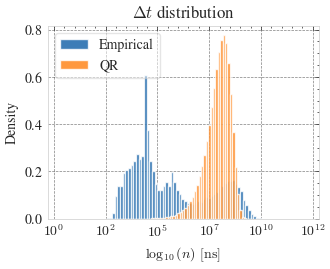

In [8]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    ax.hist(dt["dt_log"], bins=80, label="Empirical", density=True, alpha=0.8)
    ax.hist(dt_exp["dt_log"], bins=80, label="QR", density=True, alpha=0.8, color="tab:orange")
    
    ax.set_ylabel("Density")
    ax.set_xlabel(r"$\log_{10}(n)\text{ [ns] }$")
    ax.set_title(rf"$\Delta t$ distribution")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
    plt.legend(loc=0, framealpha=.5)
    plt.show()
    fig.savefig("../paper/delta_t_emp_vs_qr_exp_PFE.pdf", bbox_inches="tight")

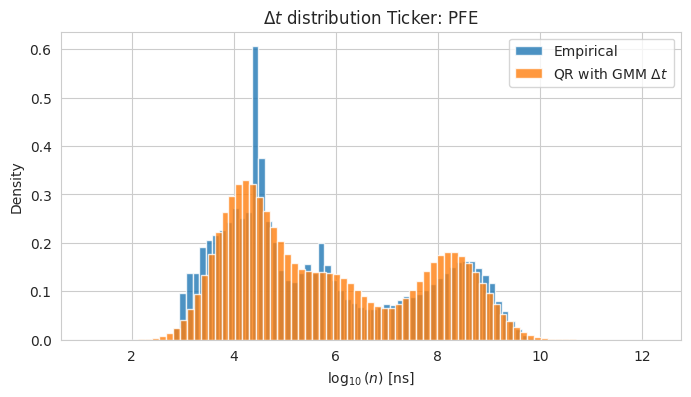

In [9]:
plt.figure(figsize=(8, 4))

plt.hist(dt["dt_log"], bins=80, label="Empirical", density=True, alpha=0.8)
plt.hist(dt_mix["dt_log"], bins=80, label=r"QR with GMM $\Delta t$", density=True, alpha=0.8)

plt.ylabel("Density")
plt.xlabel(r"$\log_{10}(n)\text{ [ns] }$")
plt.title(rf"$\Delta t$ distribution Ticker: {ticker}")
plt.legend()
save_fig("dt_distribution_emp_vs_qr_gmm")
plt.show()

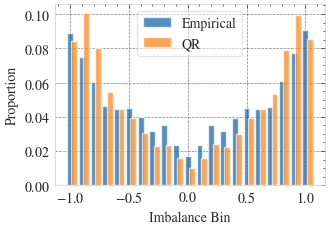

In [9]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    imb = df.filter(pl.col("event").eq("Trd"))["imb_bin"].value_counts(normalize=True).sort("imb_bin")
    imb_exp = df_exp.filter(pl.col("event").eq("Trade"))["imb_bin"].value_counts(normalize=True).sort("imb_bin")
    # imb_exp_lvl = df_exp_lvl.filter(pl.col("event").eq("Trade"))["imb_bin"].value_counts(normalize=True).sort("imb_bin")
    
    x = imb["imb_bin"]
    width = 0.05
    
    ax.bar(x, imb["proportion"], width, label="Empirical", alpha=0.7)
    ax.bar(x + width*3/4, imb_exp["proportion"], width, label="QR", alpha=0.7,color="tab:orange")
    # ax.bar(x + 1.5*width / 2, imb_exp_lvl["proportion"], width, label="QR with 3D", alpha=0.7)
    
    ax.set_xlabel("Imbalance Bin")
    ax.set_ylabel("Proportion")
    ax.legend(framealpha=.5)
    # ax.set_title(f"Binned imbalance distribution (before a trade) Ticker: {ticker}")
    fig.savefig("../paper/imb_distrib_before_trade_PFE.pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.show()

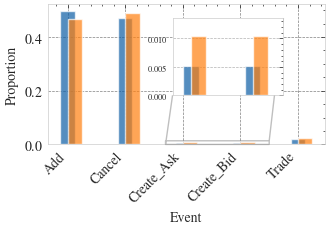

In [31]:
with plt.style.context(["science", "grid", "no-latex"]):                                                                                                                  
      fig, ax = plt.subplots(figsize=(3.5, 2.5))                                                                                                                            
                                                                                                                                                                            
      event_dist = df["event"].value_counts(normalize=True).with_columns(event=pl.col("event").replace({"Can": "Cancel", "Trd": "Trade"})).sort("event")
      event_dist_exp = df_exp["event"].value_counts(normalize=True).sort("event")                                                                                           
                                                                                                                                                                            
      labels = event_dist["event"]
      x = np.arange(len(labels))
      width = 0.25

      ax.bar(x, event_dist["proportion"], width, label="Empirical", alpha=0.7)
      ax.bar(x + width/2, event_dist_exp["proportion"], width, label="QR", alpha=0.7, color="tab:orange")

      ax.set_xticks(x)
      ax.set_xticklabels(labels, rotation=45, ha="right")
      ax.set_xlabel("Event")
      ax.set_ylabel("Proportion")
      # ax.legend()

      # Zoom patch on Create_Bid / Create_Ask region
      create_idx = [i for i, l in enumerate(labels) if "Create" in l]
      x1 = min(create_idx) - 0.3
      x2 = max(create_idx) + 0.5
      y1 = 0
      y2 = max(max(event_dist["proportion"][i] for i in create_idx),
               max(event_dist_exp["proportion"][i] for i in create_idx)) * 1.3

      axins = ax.inset_axes([0.45, 0.35, 0.4, 0.55])
      axins.bar(x[create_idx], [event_dist["proportion"][i] for i in create_idx], width, alpha=0.7)
      axins.bar(x[create_idx] + width/2, [event_dist_exp["proportion"][i] for i in create_idx], width, alpha=0.7, color="tab:orange")
      axins.set_xticks([])
      # axins.set_xticklabels([labels[i] for i in create_idx], fontsize=6, rotation=45, ha="right")
      axins.tick_params(labelsize=6)
      axins.grid(True, alpha=0.3)
      axins.set_xlim(x1, x2)
      axins.set_ylim(y1, y2)

      ax.indicate_inset_zoom(axins, edgecolor="grey", alpha=0.5)

      plt.tight_layout()
      fig.savefig("../paper/emp_vs_qr_event_distrib_PFE.pdf", bbox_inches="tight")
      plt.show()

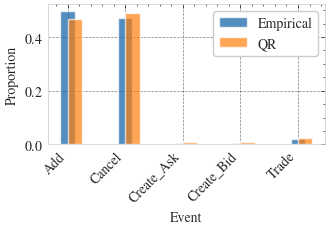

In [10]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    event_dist = df["event"].value_counts(normalize=True).with_columns(event=pl.col("event").replace({"Can": "Cancel", "Trd": "Trade"})).sort("event")
    event_dist_exp = df_exp["event"].value_counts(normalize=True).sort("event")
    # event_dist_exp_lvl = df_exp_lvl["event"].value_counts(normalize=True).sort("event")
    
    labels = event_dist["event"]
    x = np.arange(len(labels))
    width = 0.25  # narrower for 3 bars
    
    ax.bar(x, event_dist["proportion"], width, label="Empirical", alpha=0.7)
    ax.bar(x + width/2, event_dist_exp["proportion"], width, label="QR", alpha=0.7, color="tab:orange")
    # ax.bar(x + 1.5*width/2, event_dist_exp_lvl["proportion"], width, label="QR with 3D", alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_xlabel("Event")
    ax.set_ylabel("Proportion")
    ax.legend()
    # ax.set_title(f"Event Type Distribution - Ticker: {ticker}")
    
    plt.tight_layout()
    # save_fig("event_type_distribution_emp_vs_qr")
    fig.savefig("../paper/emp_vs_qr_event_distrib_PFE.pdf", bbox_inches="tight")
    plt.show()


/tmp/ipykernel_2928226/68156675.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(daily_counts, labels=labels, patch_artist=True)


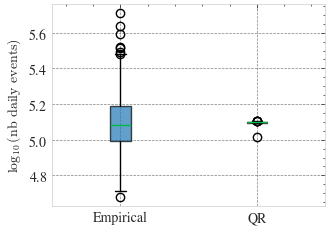

In [12]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    # Prepare data: daily event counts (log10)
    daily_counts = [
      np.log10(df.group_by("date").len()["len"]),
      np.log10(df_exp.group_by("date").len()["len"]),
      # np.log10(df_mix.group_by("date").len()["len"]),
    ]
    labels = ["Empirical", "QR"]#, r"QR with GMM $\Delta t$"]
    colors = ["tab:blue", "tab:orange"]#, "tab:green"]
    
    bp = ax.boxplot(daily_counts, labels=labels, patch_artist=True)
    
    for patch, color in zip(bp["boxes"], colors):
      patch.set_facecolor(color)
      patch.set_alpha(0.7)
    
    ax.set_ylabel(r"$\log_{10}(\text{nb daily events})$")
    # ax.set_title(f"Distribution of Daily Event Counts Ticker: {ticker}")
    
    plt.tight_layout()
    # save_fig("nb_daily_events_distribution_emp_vs_qr")
    fig.savefig("../paper/distrib_n_daily_events_PFE.pdf", bbox_inches="tight")
    plt.show()

/tmp/ipykernel_2928226/1069065238.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([sz, sze], labels=labels, patch_artist=True)


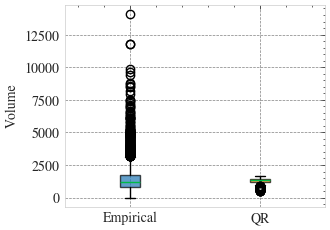

In [16]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    sz = (
      df.filter(pl.col("event").eq("Trd"))
      .group_by(pl.col("date"), pl.col("ts_event").dt.hour())
      .agg(pl.col("event_size").truediv(201).ceil().cast(int).sum())["event_size"]
    )
    sze = (
      df_exp.filter(pl.col("event").eq("Trade"))
      .group_by(pl.col("date"), pl.col("ts_event") // HOUR_NS)
      .agg(pl.col("event_size").sum())["event_size"]
    )
    # szm = (
    #   df_mix.filter(pl.col("event").eq("Trade"))
    #   .group_by(pl.col("date"), pl.col("ts_event") // HOUR_NS)
    #   .agg(pl.col("event_size").sum())["event_size"]
    # )
    
    labels = ["Empirical", "QR"]#, r"QR with GMM $\Delta t$"]
    colors = ["tab:blue", "tab:orange"]#, "tab:green"]
    
    # bp = ax.boxplot([sz, sze, szm], labels=labels, patch_artist=True)
    bp = ax.boxplot([sz, sze], labels=labels, patch_artist=True)
    
    for patch, color in zip(bp["boxes"], colors):
      patch.set_facecolor(color)
      patch.set_alpha(0.7)
    
    ax.set_ylabel(r"Volume")
    # ax.set_title(f"Distribution of Hourly Traded Volume Ticker: {ticker}")
    
    plt.tight_layout()
    # save_fig("hourly_traded_volume_distribution_emp_vs_qr")
    fig.savefig("../paper/hourly_traded_volume_PFE.pdf", bbox_inches="tight")
    plt.show()

In [14]:
sz.mean()

1467.7384312438464

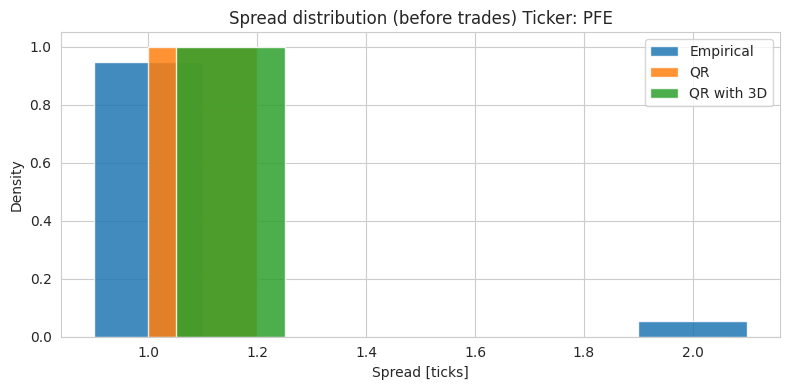

In [15]:
# Spread distribution
fig, ax = plt.subplots(figsize=(8, 4))

spread_dist = df.filter(pl.col("event").eq("Trd"))["spread"].value_counts(normalize=True).sort("spread")
spread_dist_exp = (
    df_exp.filter(pl.col("event").eq("Trade")).select(spread=(pl.col("P_1") - pl.col("P_-1")))["spread"]
    .value_counts(normalize=True)
    .sort("spread")
)
spread_dist_exp_lvl = (
    df_exp.filter(pl.col("event").eq("Trade")).select(spread=(pl.col("P_1") - pl.col("P_-1")))["spread"]
    .value_counts(normalize=True)
    .sort("spread")
)

x = spread_dist["spread"]
width = 0.2

ax.bar(x, spread_dist["proportion"], width, label="Empirical", alpha=0.85)
ax.bar(
    spread_dist_exp["spread"] + width / 2,
    spread_dist_exp["proportion"],
    width,
    label="QR",
    alpha=0.85,
)
ax.bar(
    spread_dist_exp_lvl["spread"] + 1.5*width / 2,
    spread_dist_exp_lvl["proportion"],
    width,
    label="QR with 3D",
    alpha=0.85,
)

ax.set_xlabel("Spread [ticks]")
ax.set_ylabel("Density")
ax.legend()
ax.set_title(f"Spread distribution (before trades) Ticker: {ticker}")

plt.tight_layout()
save_fig("spread_distribution_before_trades_emp_vs_qr")
plt.show()

/tmp/ipykernel_2928226/2694912457.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(vol_data, labels=labels, patch_artist=True)


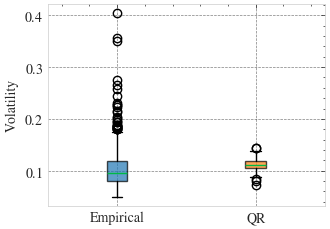

In [19]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    vol = compute_volatility_sampled_empirical(df)
    vol_exp = compute_volatility_sampled_simulation(df_exp)
    # vol_mix = compute_volatility_sampled_simulation(df_mix)
    
    labels = ["Empirical", "QR"]#, r"QR with GMM $\Delta t$"]
    colors = ["tab:blue", "tab:orange"]#, "tab:green"]
    
    vol_data = [
      vol["volatility_per_hour"].to_numpy(),
      vol_exp["volatility_per_hour"].to_numpy(),
      # vol_mix["volatility_per_hour"].to_numpy()
    ]
    bp = ax.boxplot(vol_data, labels=labels, patch_artist=True)
    
    for patch, color in zip(bp["boxes"], colors):
      patch.set_facecolor(color)
      patch.set_alpha(0.7)
    
    ax.set_ylabel(r"Volatility")
    # ax.set_title(f"Distribution of Volatility Ticker: {ticker}")
    
    plt.tight_layout()
    # save_fig("5min_vol_daily_distribution_emp_vs_qr")
    fig.savefig("../paper/volatility_5m_PFE.pdf", bbox_inches="tight")
    plt.show()

/tmp/ipykernel_2928226/3194936347.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(eta_data, labels=labels, patch_artist=True)


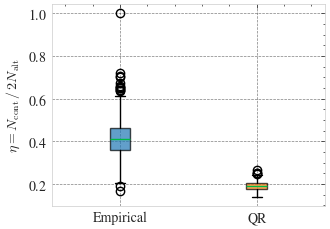

In [21]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    
    eta = compute_eta(df.filter(pl.col("event").eq("Trd")))
    eta_exp = compute_eta(df_exp.filter(pl.col("event").eq("Trade")))
    # eta_exp_lvl = compute_eta(df_exp_lvl.filter(pl.col("event").eq("Trade")))
    
    labels = ["Empirical", "QR"]#, r"QR with GMM $\Delta t$"]
    colors = ["tab:blue", "tab:orange"]#, "tab:green"]
    
    eta_data = [
      eta["eta"].to_numpy(),
      eta_exp["eta"].to_numpy(),
      # eta_exp_lvl["eallta"].to_numpy()
    ]
    bp = ax.boxplot(eta_data, labels=labels, patch_artist=True)
    
    for patch, color in zip(bp["boxes"], colors):
      patch.set_facecolor(color)
      patch.set_alpha(0.7)
    
    ax.set_ylabel(r"$\eta = N_{\mathrm{cont}} \,/\, 2 N_{\mathrm{alt}}$")
    # ax.set_title(rf"Distribution of $\eta = N_{{\mathrm{{cont}}}} \,/\, 2 N_{{\mathrm{{alt}}}}$ (In trade space) Ticker: {ticker}")
    
    plt.tight_layout()
    # save_fig("eta_distribution_emp_vs_qr")
    fig.savefig("../paper/eta_PFE.pdf", bbox_inches="tight")
    plt.show()

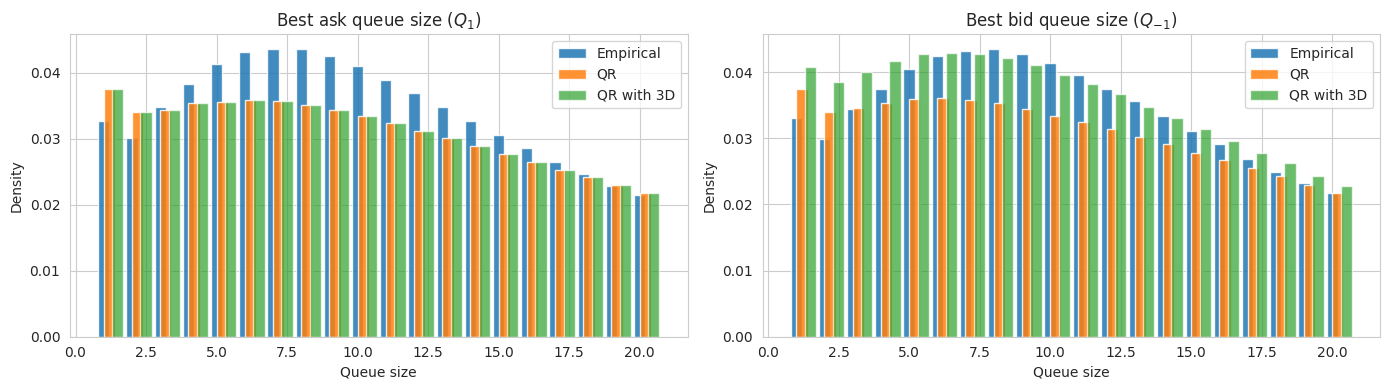

In [18]:
# Queue size at BBO distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(201).ceil()

condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(201).ceil()

# Q_1 (best ask)
q1_emp = (
    df.select(best_ask.cast(int))["best_ask"].value_counts(normalize=True)
    .sort("best_ask")
    .filter(pl.col("best_ask").le(20))
)
q1_exp = df_exp["Q_1"].value_counts(normalize=True).sort("Q_1").filter(pl.col("Q_1").le(20))
q1_exp_lvl = df_exp_lvl["Q_1"].value_counts(normalize=True).sort("Q_1").filter(pl.col("Q_1").le(20))

ax1.bar(q1_emp["best_ask"], q1_emp["proportion"], 0.4, label="Empirical", alpha=0.85)
ax1.bar(q1_exp["Q_1"] + 0.2, q1_exp["proportion"], 0.4, label="QR", alpha=0.85)
ax1.bar(q1_exp_lvl["Q_1"] + 0.5, q1_exp["proportion"], 0.4, label="QR with 3D", alpha=0.7)
ax1.set_xlabel("Queue size")
ax1.set_ylabel("Density")
ax1.set_title("Best ask queue size ($Q_1$)")
ax1.legend()

# Q_-1 (best bid)
qm1_emp = (
    df.select(best_bid.cast(int))["best_bid"].value_counts(normalize=True)
    .sort("best_bid")
    .filter(pl.col("best_bid").le(20))
)
qm1_exp = (
    df_exp["Q_-1"].value_counts(normalize=True).sort("Q_-1").filter(pl.col("Q_-1").le(20))
)
qm1_exp_lvl = (
    df_exp_lvl["Q_-1"].value_counts(normalize=True).sort("Q_-1").filter(pl.col("Q_-1").le(20))
)

ax2.bar(qm1_emp["best_bid"], qm1_emp["proportion"], 0.4, label="Empirical", alpha=0.85)
ax2.bar(qm1_exp["Q_-1"] + 0.2, qm1_exp["proportion"], 0.4, label="QR", alpha=0.85)
ax2.bar(qm1_exp_lvl["Q_-1"] + 0.5, qm1_exp_lvl["proportion"], 0.4, label="QR with 3D", alpha=0.7)
ax2.set_xlabel("Queue size")
ax2.set_ylabel("Density")
ax2.set_title("Best bid queue size ($Q_{-1}$)")
ax2.legend()

plt.tight_layout()
save_fig("queue_size_distribution_emp_vs_qr")
plt.show()